<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [2]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [7]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [8]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data_reader.py  __pycache__  security_plotter.py
data	       LICENSE	       README.md


In [9]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [10]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [11]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 17:26:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [12]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [13]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 5.3MB/s 
     |████████████████████████████████| 143kB 48.2MB/s 
     |████████████████████████████████| 143kB 55.7MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 174kB 56.5MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 6n0vnb9v
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/6n0vnb9v


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: fhx134fm with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 28s 36ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - mean_absolute_error: 0.1910 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1553
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0699 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0931
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0475 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0701
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0339 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0582
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_err

epoch,118
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01532
val_loss,0.00189
val_mean_squared_error,0.00189
val_mean_absolute_error,0.03527
_runtime,48
_timestamp,1626533161
_step,118
best_val_loss,0.00175


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: brbpkc7m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 17ms/step - loss: 0.0721 - mean_squared_error: 0.0721 - mean_absolute_error: 0.1725 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0817
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0421 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0771
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0376 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0665
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0337 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0629
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_erro

epoch,70
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01667
val_loss,0.00529
val_mean_squared_error,0.00529
val_mean_absolute_error,0.05865
_runtime,20
_timestamp,1626533192
_step,70
best_val_loss,0.0019


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▇▅▄▄▃▂▃▂▂▂▂▂▁▂▂▁▃▁▂▂▂▂▁▂▁▁▂▁▁▁▂▂▁▄▁▁▁▁▃
val_mean_squared_error,█▇▅▄▄▃▂▃▂▂▂▂▂▁▂▂▁▃▁▂▂▂▂▁▂▁▁▂▁▁▁▂▂▁▄▁▁▁▁▃
val_mean_absolute_error,█▇▅▅▄▃▃▃▂▂▃▃▂▂▂▂▂▄▁▂▃▂▃▁▂▁▁▂▁▂▁▂▂▁▅▁▁▁▁▄
_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7mrf1g3y with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 52ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0908 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0750
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0393 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0673
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0348 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0692
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0337 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1012
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mea

epoch,48
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.01813
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.04425
_runtime,9
_timestamp,1626533214
_step,48
best_val_loss,0.00272


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▄▂▂▂▂▅▁▁▁▁▁▁▃▂▁▂▁▁▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▄▂▂▂▂▅▁▁▁▁▁▁▃▂▁▂▁▁▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▇▃▄▃▃▇▂▂▂▂▂▂▅▃▂▃▂▁▃▅▂▁▁▁▁▂▅▁▁▁▂▁▁▂▂▁
val_loss,▅▄▄█▃▄▂▃▂▃▂▂▂▁▁▂▁▁▂▂▂▁▂▁▁▁▁▁▁▃▃▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▅▄▄█▃▄▂▃▂▃▂▂▂▁▁▂▁▁▂▂▂▁▂▁▁▁▁▁▁▃▃▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▅▄▄█▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▃▄▁▁▁▁▂▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3bufqlz9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 48ms/step - loss: 0.0963 - mean_squared_error: 0.0963 - mean_absolute_error: 0.2364 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1100
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1557
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0972 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0931
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0853
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mea

epoch,49
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01865
val_loss,0.00339
val_mean_squared_error,0.00339
val_mean_absolute_error,0.04602
_runtime,9
_timestamp,1626533235
_step,49
best_val_loss,0.00339


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ln6ny0ki with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 54ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - mean_absolute_error: 0.1905 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1142
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0609 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1933
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0939 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0735
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0363 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0669
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mea

epoch,49
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01678
val_loss,0.0022
val_mean_squared_error,0.0022
val_mean_absolute_error,0.03785
_runtime,10
_timestamp,1626533256
_step,49
best_val_loss,0.0022


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▂▆▂▂▂▄▂▂▂▃▂▂▂▂▂▃▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,▄█▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▂▂▂▂▂▃▂▂▁▃▂▂▁▂▃▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t0snhtzr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1021 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0772
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0723
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0445 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0696
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0459 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0671
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,49
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.0227
val_loss,0.00311
val_mean_squared_error,0.00311
val_mean_absolute_error,0.04567
_runtime,15
_timestamp,1626533283
_step,49
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▄▅▅▅▃▇▃▅▃█▆▃▂▃▂▂▂▃▂▂▂▃▂▁▄▁▁▃▁▂▁▂▁▂▁▁▁▂
val_mean_squared_error,▆▅▄▅▅▅▃▇▃▅▃█▆▃▂▃▂▂▂▃▂▂▂▃▂▁▄▁▁▃▁▂▁▂▁▂▁▁▁▂
val_mean_absolute_error,▇▆▅▅▆▆▄▇▄▆▃█▆▃▂▃▂▂▃▄▂▂▂▃▂▂▄▁▂▃▁▃▁▂▁▂▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e56lsvsk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 48ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1287 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0777
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0750
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0444 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0716
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0682
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mea

epoch,32
loss,0.00105
mean_squared_error,0.00105
mean_absolute_error,0.02519
val_loss,0.01208
val_mean_squared_error,0.01208
val_mean_absolute_error,0.0871
_runtime,7
_timestamp,1626533303
_step,32
best_val_loss,0.00469


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▃▃▄▃▃▃▂▄▂▃▃▂▃▂▂▃▂▃▁▃▁▃▁▂▂▁▃▁
val_loss,▅▅▃▃▃▄▃▆█▅▂▂▂▃▁▂▁▁▃▁▁▁▁▄▃▁▂▄▁▃▃▂▆
val_mean_squared_error,▅▅▃▃▃▄▃▆█▅▂▂▂▃▁▂▁▁▃▁▁▁▁▄▃▁▂▄▁▃▃▂▆
val_mean_absolute_error,▅▅▄▄▃▅▃▆█▅▂▃▂▄▂▃▂▂▄▂▂▂▁▅▃▁▂▅▁▄▃▂▇
_runtime,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████████
_timestamp,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 0vhf4jns with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 1s 14ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2059 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0809
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0707
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0374 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0703
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0676
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,65
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.0155
val_loss,0.00239
val_mean_squared_error,0.00239
val_mean_absolute_error,0.03928
_runtime,17
_timestamp,1626533334
_step,65
best_val_loss,0.00214


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: iugd2npc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 25ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - mean_absolute_error: 0.1709 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0742
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0559 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0761
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0565 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1075
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0587 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0677
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_erro

epoch,34
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02932
val_loss,0.00224
val_mean_squared_error,0.00224
val_mean_absolute_error,0.03809
_runtime,9
_timestamp,1626533358
_step,34
best_val_loss,0.00207


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▁▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▁▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▅▃▄▃▄▄▄▃▃▃▂▃▂▂▃▂▃▂▃▂▃▂▃▂▂▂▂▃▁▂▂
val_loss,▄▄█▄▄▂▃▄▂▂▂▃▂▅▁▁▃▁▁▁▁▂▂▁▁▂▁▂▁▁▁▁▃▁▁
val_mean_squared_error,▄▄█▄▄▂▃▄▂▂▂▃▂▅▁▁▃▁▁▁▁▂▂▁▁▂▁▂▁▁▁▁▃▁▁
val_mean_absolute_error,▅▅█▄▅▃▃▅▂▂▂▃▃▅▂▂▃▁▁▁▁▃▂▁▁▂▁▃▁▁▁▁▃▂▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆█████████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆█████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a6784vgs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - mean_absolute_error: 0.1605 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0847
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0458 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0808
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0386 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0738
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0362 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0672
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,49
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01554
val_loss,0.0023
val_mean_squared_error,0.0023
val_mean_absolute_error,0.03874
_runtime,14
_timestamp,1626533385
_step,49
best_val_loss,0.00213


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▄▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▃▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v1fkfan8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 27ms/step - loss: 0.1276 - mean_squared_error: 0.1276 - mean_absolute_error: 0.2554 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1029
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0832
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0451 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0783
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0407 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0794
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,82
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.02017
val_loss,0.0022
val_mean_squared_error,0.0022
val_mean_absolute_error,0.03764
_runtime,17
_timestamp,1626533414
_step,82
best_val_loss,0.00207


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▃▂▂▂▂▂▂▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▃▂▂▂▂▂▂▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▃▃▃▃▂▃▂▂▂▄▂▂▂▂▂▂▂▃▁▁▁▁▂▁▁▁▂▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vrdcrpca with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 23ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - mean_absolute_error: 0.1742 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0777
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0561 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0811
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0717
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0386 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0724
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.

epoch,49
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01609
val_loss,0.00234
val_mean_squared_error,0.00234
val_mean_absolute_error,0.03864
_runtime,12
_timestamp,1626533443
_step,49
best_val_loss,0.00234


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,▇█▆▆▄▃▃▂▂▂▂▂▂▄▃▂▂▂▁▂▂▁▂▂▂▁▁▁▁▂▁▁▂▁▁▂▂▁▁▁
val_mean_squared_error,▇█▆▆▄▃▃▂▂▂▂▂▂▄▃▂▂▂▁▂▂▁▂▂▂▁▁▁▁▂▁▁▂▁▁▂▂▁▁▁
val_mean_absolute_error,▇█▆▇▅▄▃▃▃▃▃▃▃▅▄▃▂▂▂▂▂▂▂▂▃▂▂▂▁▃▁▁▂▂▁▃▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qh31wtd0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 15ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1158 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0864
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0634 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0616
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0360 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0627
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0378 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1204
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_squared_erro

epoch,60
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02166
val_loss,0.00416
val_mean_squared_error,0.00416
val_mean_absolute_error,0.04953
_runtime,19
_timestamp,1626533474
_step,60
best_val_loss,0.00241


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▅▃▂▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▅▃▂▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▆▆▃▄█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▂▂▁▂▁▁▂▂▂▁▁▁
val_loss,▅▃█▂▄▃▂▂▂▂▂▂▂▁▇▁▃▁▃▂▁▃▁▁▂▂▂▁▂▁▂▁▁▁▂▂▂▃▂▂
val_mean_squared_error,▅▃█▂▄▃▂▂▂▂▂▂▂▁▇▁▃▁▃▂▁▃▁▁▂▂▂▁▂▁▂▁▁▁▂▂▂▃▂▂
val_mean_absolute_error,▅▃█▃▅▃▃▂▂▂▂▃▂▂▇▁▃▁▃▂▁▄▂▁▂▂▂▁▃▂▃▁▁▁▃▂▃▄▂▂
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: egc40gis with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 46ms/step - loss: 0.1132 - mean_squared_error: 0.1132 - mean_absolute_error: 0.2405 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1131
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0923 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1333
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0717 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0780
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0810
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 

epoch,99
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01409
val_loss,0.00196
val_mean_squared_error,0.00196
val_mean_absolute_error,0.03566
_runtime,14
_timestamp,1626533505
_step,99
best_val_loss,0.00196


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4yn5oox3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 51ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - mean_absolute_error: 0.2165 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0931
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0869
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0817
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0409 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0751
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mea

epoch,40
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.02521
val_loss,0.00512
val_mean_squared_error,0.00512
val_mean_absolute_error,0.05525
_runtime,10
_timestamp,1626533528
_step,40
best_val_loss,0.00466


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▂▂▁▂▁▂▁▂▁▁▁
val_loss,▇▇▆▄▅▇▄▃▄▄█▄▇▃▂▂▂▃▂▂▂▃▃▂▁▁▁▁▁▁▁▂▁▁▂▂▂▄▂▁
val_mean_squared_error,▇▇▆▄▅▇▄▃▄▄█▄▇▃▂▂▂▃▂▂▂▃▃▂▁▁▁▁▁▁▁▂▁▁▂▂▂▄▂▁
val_mean_absolute_error,█▇▆▅▅▆▄▄▄▄█▄▇▃▃▂▃▃▃▂▂▃▃▁▁▁▂▁▂▁▁▂▁▁▂▂▂▄▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: y8n3bznn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 16ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1069 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1086
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0712 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0652
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0474 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0577
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0509 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0579
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_erro

epoch,44
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01715
val_loss,0.00277
val_mean_squared_error,0.00277
val_mean_absolute_error,0.04192
_runtime,16
_timestamp,1626533557
_step,44
best_val_loss,0.00254


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▃▅▂▂▆▂▂▂▂▁▆▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▆▃▅▂▂▆▂▂▂▂▁▆▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▆▃▃▆▂▂▃▃▂▆▂▂▂▂▂▂▁▂▃▂▂▂▂▂▂▂▁▁▁▃▁▂▁▁▁▁▁
val_loss,█▃▂▂▂▂▃▃▄▂▂▂▂▂▂▁▁▁▁▂▂▁▂▂▂▁▂▅▁▂▁▁▂▂▂▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▃▃▄▂▂▂▂▂▂▁▁▁▁▂▂▁▂▂▂▁▂▅▁▂▁▁▂▂▂▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▄▄▂▂▂▂▃▂▂▂▂▂▂▂▂▃▂▂▁▂▆▁▂▁▁▂▂▂▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1u6is7u6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 48ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1776 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0965
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0638 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0749
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0519 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0969
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0463 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0732
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 

epoch,59
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01725
val_loss,0.00257
val_mean_squared_error,0.00257
val_mean_absolute_error,0.04108
_runtime,11
_timestamp,1626533583
_step,59
best_val_loss,0.0023


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▅▄▄▄▃▃▃▂▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▅▄▄▄▃▃▃▂▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jkwghq5u with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 15ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1023 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0864
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0603
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0280 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0564
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0252 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0535
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_erro

epoch,58
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01527
val_loss,0.002
val_mean_squared_error,0.002
val_mean_absolute_error,0.03548
_runtime,18
_timestamp,1626533617
_step,58
best_val_loss,0.00192


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oen2yfnl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 27ms/step - loss: 0.1609 - mean_squared_error: 0.1609 - mean_absolute_error: 0.2987 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1012
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0718 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0858
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0441 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0721
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0369 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0716
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01726
val_loss,0.00276
val_mean_squared_error,0.00276
val_mean_absolute_error,0.04211
_runtime,14
_timestamp,1626533645
_step,49
best_val_loss,0.00276


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eporr1xi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 49ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - mean_absolute_error: 0.2552 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0878
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0900 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1448
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0731 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0826
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0622 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0735
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 

epoch,99
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01605
val_loss,0.00286
val_mean_squared_error,0.00286
val_mean_absolute_error,0.04185
_runtime,15
_timestamp,1626533682
_step,99
best_val_loss,0.00278


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nc1h2dcz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 53ms/step - loss: 0.1627 - mean_squared_error: 0.1627 - mean_absolute_error: 0.2530 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0869
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0619 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0770
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0620
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0447 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1424
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0154 - mean_squared_error: 0.0154

epoch,89
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01826
val_loss,0.0021
val_mean_squared_error,0.0021
val_mean_absolute_error,0.03679
_runtime,16
_timestamp,1626533714
_step,89
best_val_loss,0.00204


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▂▂▃▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁
val_loss,█▄▃▅▃▄▂█▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▃▅▃▄▂█▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▇▄▄▅▃▄▃█▂▂▂▂▃▃▂▂▂▂▂▂▁▃▁▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: at9tdpx9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 2s 14ms/step - loss: 0.0892 - mean_squared_error: 0.0892 - mean_absolute_error: 0.1576 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0794
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0710 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1558
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0629 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1458
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0731 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0593
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_erro

epoch,22
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02739
val_loss,0.00371
val_mean_squared_error,0.00371
val_mean_absolute_error,0.0478
_runtime,12
_timestamp,1626533740
_step,22
best_val_loss,0.00216


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁
val_loss,▃█▇▂▁▁▂▁▁▂▂▁▁▁▁▂▁▂▃▁▁▁▁
val_mean_squared_error,▃█▇▂▁▁▂▁▁▂▂▁▁▁▁▂▁▂▃▁▁▁▁
val_mean_absolute_error,▃█▇▂▂▂▂▂▁▂▃▂▁▁▁▂▁▃▃▂▁▁▂
_runtime,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██
_timestamp,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 54o6no63 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 59ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - mean_absolute_error: 0.3030 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1423
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0969 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0870
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0816
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0420 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0765
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 

epoch,75
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01888
val_loss,0.00378
val_mean_squared_error,0.00378
val_mean_absolute_error,0.04714
_runtime,15
_timestamp,1626533771
_step,75
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6067agtt with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 50ms/step - loss: 0.1508 - mean_squared_error: 0.1508 - mean_absolute_error: 0.2876 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1016
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.1043 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1357
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0726 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0906
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0625 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0825
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032

epoch,117
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01557
val_loss,0.00234
val_mean_squared_error,0.00234
val_mean_absolute_error,0.03857
_runtime,17
_timestamp,1626533803
_step,117
best_val_loss,0.00231


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s8l97et9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1168 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1267
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0742 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0657
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0399 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0663
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0359 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1590
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0078 - mean_squared_erro

epoch,66
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02775
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.04376
_runtime,17
_timestamp,1626533835
_step,66
best_val_loss,0.00255


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▂▂▂▁▂▂▂▁▃▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▄▁▁▁▁▁▂▁▁▁▁▂▁
mean_squared_error,█▄▄▂▂▂▁▂▂▂▁▃▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▄▁▁▁▁▁▂▁▁▁▁▂▁
mean_absolute_error,█▆▅▃▃▄▂▄▃▄▂▄▄▃▃▄▄▂▃▂▁▂▃▄▁▁▂▆▂▁▁▁▁▃▂▁▁▁▃▂
val_loss,▆▂█▂▂▄▁▂▁▂▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▆▂█▂▂▄▁▂▁▂▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▆▂█▂▂▅▂▂▂▃▂▂▁▁▂▂▂▂▂▁▂▁▂▂▂▁▄▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kzutys70 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 15ms/step - loss: 0.0989 - mean_squared_error: 0.0989 - mean_absolute_error: 0.1681 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0697
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0341 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0665
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0310 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0636
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0292 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0594
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,49
loss,0.00048
mean_squared_error,0.00048
mean_absolute_error,0.01684
val_loss,0.00224
val_mean_squared_error,0.00224
val_mean_absolute_error,0.03767
_runtime,19
_timestamp,1626533869
_step,49
best_val_loss,0.00195


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▃▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▄▃▅▃▄▃▃▃▂▂▄▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▇▇▅▄▃▅▃▄▃▃▃▂▂▄▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▇▇▆▅▄▆▄▄▃▄▃▃▂▄▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o19zr51i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 52ms/step - loss: 0.0887 - mean_squared_error: 0.0887 - mean_absolute_error: 0.1947 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0955
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0778
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0414 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0703
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0362 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0655
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - m

epoch,49
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01826
val_loss,0.00334
val_mean_squared_error,0.00334
val_mean_absolute_error,0.04596
_runtime,13
_timestamp,1626533907
_step,49
best_val_loss,0.00294


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▂▂▄▂▂▁▁▂▄▁▁▁▁▁▁▁▃▂▁▁▂▂▁▁▁▂▂▃▁▁▁▂▂▁▁
val_loss,█▅▄▄▄▂▃▂▂▂▂▂▅▂▂▂▁▁▁▁▃▇▂▁▂▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▅▄▄▄▂▃▂▂▂▂▂▅▂▂▂▁▁▁▁▃▇▂▁▂▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▄▂▂▂▂▂▆▂▂▂▂▂▂▂▄█▃▂▂▄▂▁▁▁▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v9lvr98f with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1587 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0715
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0378 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0603
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0309 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0554
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0282 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0525
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_erro

epoch,63
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.0149
val_loss,0.00188
val_mean_squared_error,0.00188
val_mean_absolute_error,0.03455
_runtime,20
_timestamp,1626533963
_step,63
best_val_loss,0.00187


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▃▃▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3ti5flkl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - mean_absolute_error: 0.1684 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0741
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0475 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0714
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0389 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0682
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0360 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0689
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_erro

epoch,63
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.016
val_loss,0.00216
val_mean_squared_error,0.00216
val_mean_absolute_error,0.03723
_runtime,16
_timestamp,1626533995
_step,63
best_val_loss,0.00188


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▇▇▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▇▇▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,██▇▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▃▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3xndujfp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 27ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.0890 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1077
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0521 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0759
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0416 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0585
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0295 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0950
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0098 - mean_squared_error: 0.

epoch,49
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01647
val_loss,0.00219
val_mean_squared_error,0.00219
val_mean_absolute_error,0.03751
_runtime,15
_timestamp,1626534026
_step,49
best_val_loss,0.00186


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▁▂▄▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁
mean_squared_error,█▅▂▂▁▂▄▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁
mean_absolute_error,█▇▃▃▂▃▅▂▂▃▄▂▃▁▁▂▃▁▂▁▂▁▁▂▁▁▁▁▁▁▃▂▁▃▂▁▁▁▃▁
val_loss,█▄▃▆▂▆▂▁▁▃▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▆▂▆▂▁▁▃▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▇▂▇▂▂▂▄▃▂▂▁▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: daw78asf with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 1s 49ms/step - loss: 0.4341 - mean_squared_error: 0.4341 - mean_absolute_error: 0.4289 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0822
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0413 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0800
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0678 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0683
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0390 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1404
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mea

epoch,49
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.018
val_loss,0.00233
val_mean_squared_error,0.00233
val_mean_absolute_error,0.03948
_runtime,12
_timestamp,1626534054
_step,49
best_val_loss,0.00226


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▆▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂█▃▄▆▇▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▂█▃▄▆▇▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄▃█▄▅▆▇▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ix4eutwt with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 1s 15ms/step - loss: 0.2486 - mean_squared_error: 0.2486 - mean_absolute_error: 0.2904 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0670
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0333 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 9.2853e-04 - mean_squared_error: 9.2853e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0488
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 8.3444e-04 - mean_squared_error: 8.3444e-04 - mean_absolute_error: 0.0226 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0490
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 8.7933e-04

epoch,30
loss,0.00066
mean_squared_error,0.00066
mean_absolute_error,0.02033
val_loss,0.00267
val_mean_squared_error,0.00267
val_mean_absolute_error,0.04146
_runtime,15
_timestamp,1626534084
_step,30
best_val_loss,0.00177


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂
val_mean_squared_error,█▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂
val_mean_absolute_error,█▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▃▁▁▁▁▁▁▂▂▁▁▂▂▃
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: e3929zrm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 25ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - mean_absolute_error: 0.1825 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0788
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0391 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0772
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0412 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0735
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0383 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0729
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_erro

epoch,53
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.02328
val_loss,0.0026
val_mean_squared_error,0.0026
val_mean_absolute_error,0.04063
_runtime,14
_timestamp,1626534113
_step,53
best_val_loss,0.00248


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▄▅▄▃▄▄▅▃▂▂▃▅▄▃▂▂▂▄▂▂▁▂▁▃▂▂▄▁▁▁▁▃▃▂▃▁▁
val_mean_squared_error,██▇▄▅▄▃▄▄▅▃▂▂▃▅▄▃▂▂▂▄▂▂▁▂▁▃▂▂▄▁▁▁▁▃▃▂▃▁▁
val_mean_absolute_error,██▇▅▆▄▄▄▄▆▃▃▃▄▆▄▃▂▂▃▅▂▂▂▂▂▄▂▂▅▁▁▁▂▄▄▂▃▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tfqm2ww5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 27ms/step - loss: 4.4578 - mean_squared_error: 4.4578 - mean_absolute_error: 1.0794 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0896
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0465 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0801
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0977 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0724
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0670 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0731
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0121 - mean_squared_erro

epoch,18
loss,0.00953
mean_squared_error,0.00953
mean_absolute_error,0.06756
val_loss,0.03828
val_mean_squared_error,0.03828
val_mean_absolute_error,0.14869
_runtime,10
_timestamp,1626534138
_step,18
best_val_loss,0.00583


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▃▁▄▁▂▂▄▁▁▁▂▁▃▁
val_loss,▂▂▁▁▁▂▂▂▁█▁▅▁▁▂▂▁▁▄
val_mean_squared_error,▂▂▁▁▁▂▂▂▁█▁▅▁▁▂▂▁▁▄
val_mean_absolute_error,▂▂▁▂▁▃▃▂▁█▂▅▁▂▂▂▂▁▅
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅███
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅███
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: r7qky46f with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 15ms/step - loss: 0.0904 - mean_squared_error: 0.0904 - mean_absolute_error: 0.2144 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0903
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0447 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0792
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0410 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0783
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0379 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0740
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_erro

epoch,64
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01608
val_loss,0.00291
val_mean_squared_error,0.00291
val_mean_absolute_error,0.04286
_runtime,23
_timestamp,1626534178
_step,64
best_val_loss,0.00224


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▄▄▃▄▃▂▂▃▂▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▅▄▄▃▄▃▂▂▃▂▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: voyee6oq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0842 - mean_squared_error: 0.0842 - mean_absolute_error: 0.1919 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0803
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0745
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0354 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0691
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0642
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_squared_erro

epoch,80
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.0153
val_loss,0.00179
val_mean_squared_error,0.00179
val_mean_absolute_error,0.0343
_runtime,25
_timestamp,1626534219
_step,80
best_val_loss,0.00176


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▃▂▂▁▂▂▁▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ayogm7y3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 50ms/step - loss: 0.1540 - mean_squared_error: 0.1540 - mean_absolute_error: 0.2991 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0979
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0868 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1645
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0829 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0862
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0645 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0757
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 

epoch,141
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01427
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03751
_runtime,20
_timestamp,1626534254
_step,141
best_val_loss,0.00215


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gsmyyv36 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 14ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0908 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0747
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0648
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0384 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0677
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0356 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0577
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_erro

epoch,87
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.01841
val_loss,0.00233
val_mean_squared_error,0.00233
val_mean_absolute_error,0.03783
_runtime,26
_timestamp,1626534298
_step,87
best_val_loss,0.00199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▃▃▂▂▂▃▃▂▂▂▂▂▁▂▁▃▁▂▁▃▁▂▂▂▁▁▁▁▁▁▁▄▁▁▂▁▁
val_mean_squared_error,▅▅█▃▃▂▂▂▃▃▂▂▂▂▂▁▂▁▃▁▂▁▃▁▂▂▂▁▁▁▁▁▁▁▄▁▁▂▁▁
val_mean_absolute_error,▆▅█▃▄▃▃▂▃▃▂▂▂▂▂▂▂▁▄▂▂▂▄▂▃▃▃▁▁▁▁▁▁▂▅▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u0cwaufo with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 15ms/step - loss: 0.1644 - mean_squared_error: 0.1644 - mean_absolute_error: 0.2485 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0693
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0975 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0562
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0324 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0497
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 8.5301e-04 - mean_squared_error: 8.5301e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0548
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squa

epoch,17
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.01897
val_loss,0.00251
val_mean_squared_error,0.00251
val_mean_absolute_error,0.04006
_runtime,12
_timestamp,1626534327
_step,17
best_val_loss,0.00213


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
mean_absolute_error,▂▂▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▁▁▁▁▁▂▁▂█▁▁▁▁▁▁▁▁
_runtime,▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆███
_timestamp,▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆███
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: m8hr98e6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.3458 - mean_squared_error: 0.3458 - mean_absolute_error: 0.3532 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1053
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0714 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1253
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0819 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0574
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0352 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1276
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0695 - mean_squared_erro

epoch,51
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.02176
val_loss,0.00351
val_mean_squared_error,0.00351
val_mean_absolute_error,0.0465
_runtime,15
_timestamp,1626534358
_step,51
best_val_loss,0.00192


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
mean_absolute_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t67p8232 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 15ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0906 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0815
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0440 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0606
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0393 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0533
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0341 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0536
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_erro

epoch,75
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01484
val_loss,0.0018
val_mean_squared_error,0.0018
val_mean_absolute_error,0.03404
_runtime,27
_timestamp,1626534400
_step,75
best_val_loss,0.00177


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▁▇▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▁▇▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▄▃▂▂▂▃▂▂█▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: d7t1b3ya with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 16ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1183 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0852
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0685 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0862
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0473 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0635
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0390 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0568
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_erro

epoch,36
loss,0.00293
mean_squared_error,0.00293
mean_absolute_error,0.03768
val_loss,0.00318
val_mean_squared_error,0.00318
val_mean_absolute_error,0.0454
_runtime,18
_timestamp,1626534433
_step,36
best_val_loss,0.00268


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▃▂▂▃▁▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
mean_squared_error,█▅▃▃▃▂▂▃▁▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
mean_absolute_error,█▆▅▄▅▄▃▄▂▄▃▃▂▂▃▂▁▂▃▂▁▂▁▂▂▂▁▁▂▂▁▃▁▁▁▁▄
val_loss,▃▃▂▂▂▂▂▁▁▁▃▂▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▃▂▂▂▂▂▁▁▁▃▂▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄▂▂▂▂▂▂▁▂▃▃▂█▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tzwyqte6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.3665 - mean_squared_error: 0.3665 - mean_absolute_error: 0.3529 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0675
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0590 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0647
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0563 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0516
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0285 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0850
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.

epoch,49
loss,0.09709
mean_squared_error,0.09709
mean_absolute_error,0.14675
val_loss,0.00377
val_mean_squared_error,0.00377
val_mean_absolute_error,0.04928
_runtime,15
_timestamp,1626534463
_step,49
best_val_loss,0.00213


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
mean_absolute_error,▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3ml4xwta with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 47ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - mean_absolute_error: 0.2032 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1145
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0784 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0959
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0696
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0438 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0641
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 

epoch,99
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01813
val_loss,0.00228
val_mean_squared_error,0.00228
val_mean_absolute_error,0.03806
_runtime,17
_timestamp,1626534495
_step,99
best_val_loss,0.00187


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xfip7x9q with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 51ms/step - loss: 0.1593 - mean_squared_error: 0.1593 - mean_absolute_error: 0.2891 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0971
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.1037 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1143
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0555 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0846
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0585 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0762
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.003

epoch,86
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01657
val_loss,0.00262
val_mean_squared_error,0.00262
val_mean_absolute_error,0.04075
_runtime,16
_timestamp,1626534527
_step,86
best_val_loss,0.00245


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▇▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g1je5zv2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 25ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - mean_absolute_error: 0.2126 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0854
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0463 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0712
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0392 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0732
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0433 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0678
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_erro

epoch,112
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.01884
val_loss,0.00252
val_mean_squared_error,0.00252
val_mean_absolute_error,0.03966
_runtime,24
_timestamp,1626534566
_step,112
best_val_loss,0.00209


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅█▄▅▃▃▂▂▂▂▂▂▂▂▁▃▂▂▁▃▂▁▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▅█▄▅▃▃▂▂▂▂▂▂▂▂▁▃▂▂▁▃▂▁▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆█▄▅▄▄▃▃▃▃▂▂▂▂▂▃▂▃▁▃▂▂▁▁▁▄▁▁▁▃▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4n3kqmrw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 15ms/step - loss: 0.0581 - mean_squared_error: 0.0581 - mean_absolute_error: 0.1602 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0733
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0369 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0681
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0333 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0643
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0325 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0601
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,46
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01508
val_loss,0.00214
val_mean_squared_error,0.00214
val_mean_absolute_error,0.03687
_runtime,19
_timestamp,1626534600
_step,46
best_val_loss,0.00211


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7f8cgq14 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 26ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0957 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1106
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0658
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0390 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0612
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0310 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0609
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_erro

epoch,99
loss,0.00034
mean_squared_error,0.00034
mean_absolute_error,0.0142
val_loss,0.00185
val_mean_squared_error,0.00185
val_mean_absolute_error,0.03502
_runtime,22
_timestamp,1626534642
_step,99
best_val_loss,0.00185


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 179depub with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 16ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - mean_absolute_error: 0.2107 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0849
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0387 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0705
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0375 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0690
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0350 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0622
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_erro

epoch,83
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.01556
val_loss,0.00219
val_mean_squared_error,0.00219
val_mean_absolute_error,0.03742
_runtime,30
_timestamp,1626534693
_step,83
best_val_loss,0.00196


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e5gzd6hc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 26ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1325 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1263
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0790 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0690
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0444 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0684
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0350 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0620
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,49
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01651
val_loss,0.00216
val_mean_squared_error,0.00216
val_mean_absolute_error,0.03684
_runtime,16
_timestamp,1626534724
_step,49
best_val_loss,0.00184


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▃▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁
mean_squared_error,█▄▃▂▃▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁
mean_absolute_error,█▆▅▃▅▂▂▂▂▅▁▁▁▁▁▂▁▁▁▂▁▁▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▅▂▁
val_loss,█▃▃▂▂▂▂▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▃▃▂▂▂▂▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▄▄▃▃▂▂▂█▂▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8p981i97 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.2207 - mean_squared_error: 0.2207 - mean_absolute_error: 0.2883 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0718
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0586 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0753
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0826 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1871
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1133 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0837
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0166 - mean_squared_erro

epoch,17
loss,0.00333
mean_squared_error,0.00333
mean_absolute_error,0.04517
val_loss,0.00711
val_mean_squared_error,0.00711
val_mean_absolute_error,0.06183
_runtime,10
_timestamp,1626534751
_step,17
best_val_loss,0.0064


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▃▃▂▂▂▂▁▁▂▂▁▁▁▁
val_loss,▁▁█▂▂▁▁▁▄▁▁▂▂▂▂▁▁▁
val_mean_squared_error,▁▁█▂▂▁▁▁▄▁▁▂▂▂▂▁▁▁
val_mean_absolute_error,▂▂█▂▃▂▁▁▅▁▁▃▃▃▂▁▁▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅██████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅██████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: gx9vddm5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 28ms/step - loss: 0.1182 - mean_squared_error: 0.1182 - mean_absolute_error: 0.2438 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0863
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0447 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0733
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0419 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0726
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0422 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0684
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_erro

epoch,46
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.0198
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04801
_runtime,15
_timestamp,1626534782
_step,46
best_val_loss,0.00249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,█▅▅▅▅▄▃▄▂▂▃▂▃▂▃▂▃▂▂▄▂▂▁▂▁▁▁▂▁▂▁▁▃▁▁▁▁▁▁▂
val_mean_squared_error,█▅▅▅▅▄▃▄▂▂▃▂▃▂▃▂▃▂▂▄▂▂▁▂▁▁▁▂▁▂▁▁▃▁▁▁▁▁▁▂
val_mean_absolute_error,█▆▆▅▅▄▄▄▃▃▃▃▃▂▄▂▃▃▃▅▂▂▂▂▁▁▁▂▂▂▁▁▃▁▁▁▂▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q9h4n0vr with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 75ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - mean_absolute_error: 0.1918 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0879
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1005
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0452 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0934
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0487 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1011
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0

epoch,67
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.03077
val_loss,0.00458
val_mean_squared_error,0.00458
val_mean_absolute_error,0.05117
_runtime,14
_timestamp,1626534811
_step,67
best_val_loss,0.00336


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▂
val_loss,▆██▄▄▂▃▅▄▂▃▃▇▃▄▂▂▁▃▁▁▁▁▁▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂
val_mean_squared_error,▆██▄▄▂▃▅▄▂▃▃▇▃▄▂▂▁▃▁▁▁▁▁▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂
val_mean_absolute_error,▆██▄▄▃▃▅▄▃▃▃▇▄▄▂▃▂▃▁▁▂▂▁▃▂▃▁▁▁▁▁▂▂▂▁▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y115ctkx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 16ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - mean_absolute_error: 0.2113 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0788
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0415 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0738
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0380 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0700
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0336 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0621
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,49
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01766
val_loss,0.00223
val_mean_squared_error,0.00223
val_mean_absolute_error,0.03761
_runtime,21
_timestamp,1626534856
_step,49
best_val_loss,0.00223


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁
val_loss,█▇▇▅▄▃▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▇▇▅▄▃▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▇▅▄▄▄▄▄▄▄▃▄▃▂▃▃▃▂▂▂▂▃▂▂▁▂▁▃▁▃▂▂▁▁▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: djv3hpa0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 16ms/step - loss: 0.0944 - mean_squared_error: 0.0944 - mean_absolute_error: 0.2156 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0862
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0758
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0415 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0750
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0386 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0694
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_erro

epoch,67
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01483
val_loss,0.00212
val_mean_squared_error,0.00212
val_mean_absolute_error,0.03654
_runtime,27
_timestamp,1626534898
_step,67
best_val_loss,0.0021


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▃▄▄▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▃▄▄▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▃▄▄▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yq5wdr9p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1018 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0769
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0634 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0641
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0393 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0714
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0436 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0582
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,67
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01734
val_loss,0.00237
val_mean_squared_error,0.00237
val_mean_absolute_error,0.03855
_runtime,26
_timestamp,1626534938
_step,67
best_val_loss,0.0023


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▂▇▂▁▂▂▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁
mean_squared_error,█▅▄▂▇▂▁▂▂▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁
mean_absolute_error,█▇▆▄▇▃▂▃▃▃▃▅▂▂▁▂▁▂▂▄▁▃▂▁▁▁▁▂▁▁▁▂▃▁▃▁▁▁▁▁
val_loss,▅▃▃▂▃▂▂▆▂▂▆▆▁▁▂▂▂▂▁▃▃▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▃▃▂▃▂▂▆▂▂▆▆▁▁▂▂▂▂▁▃▃▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▄▃▃▃▃▂▆▂▃▆▇▁▁▂▂▂▃▁▄▄▂▁█▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n8e51yqf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 16ms/step - loss: 0.2864 - mean_squared_error: 0.2864 - mean_absolute_error: 0.3355 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0718
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0473 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0529
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0277 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0498
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 9.7301e-04 - mean_squared_error: 9.7301e-04 - mean_absolute_error: 0.0238 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0473
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 8.6137e-04 - mean_

epoch,50
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01457
val_loss,0.0021
val_mean_squared_error,0.0021
val_mean_absolute_error,0.03649
_runtime,22
_timestamp,1626534974
_step,50
best_val_loss,0.00181


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▄▁▂▁▁▁▂▁
val_mean_squared_error,█▃▃▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▄▁▂▁▁▁▂▁
val_mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▂▂▁▁▁▅▁▂▁▁▂▂▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h29syzwo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 50ms/step - loss: 0.3401 - mean_squared_error: 0.3401 - mean_absolute_error: 0.4485 - val_loss: 0.0689 - val_mean_squared_error: 0.0689 - val_mean_absolute_error: 0.2155
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1355 - val_loss: 0.0559 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.2032
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0965 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0955
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0641 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0717
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0

epoch,99
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.0149
val_loss,0.00184
val_mean_squared_error,0.00184
val_mean_absolute_error,0.03452
_runtime,17
_timestamp,1626535006
_step,99
best_val_loss,0.00184


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sysig8gm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 83ms/step - loss: 0.1431 - mean_squared_error: 0.1431 - mean_absolute_error: 0.2910 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1656
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1189 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0943
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0899
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0447 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0787
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.002

epoch,131
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02182
val_loss,0.00288
val_mean_squared_error,0.00288
val_mean_absolute_error,0.04203
_runtime,22
_timestamp,1626535044
_step,131
best_val_loss,0.00258


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h8w76qgj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 57ms/step - loss: 0.1143 - mean_squared_error: 0.1143 - mean_absolute_error: 0.2270 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0933
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0787
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0703
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0372 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0675
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.002

epoch,99
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.017
val_loss,0.00218
val_mean_squared_error,0.00218
val_mean_absolute_error,0.03729
_runtime,19
_timestamp,1626535085
_step,99
best_val_loss,0.00218


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▃▂▂▂▃▁▂▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▅▄▅▅▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▅▄▅▅▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▅▆▆▃▃▃▃▃▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▂▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sihkao9t with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 16ms/step - loss: 0.2022 - mean_squared_error: 0.2022 - mean_absolute_error: 0.2241 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1196
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0585 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1265
Epoch 3/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0606 - val_loss: 0.7299 - val_mean_squared_error: 0.7299 - val_mean_absolute_error: 0.8059
Epoch 4/200
32/32 [==============================] - 0s 10ms/step - loss: 0.1329 - mean_squared_error: 0.1329 - mean_absolute_error: 0.2366 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0545
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_er

epoch,27
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.0192
val_loss,0.00296
val_mean_squared_error,0.00296
val_mean_absolute_error,0.04411
_runtime,16
_timestamp,1626535145
_step,27
best_val_loss,0.00202


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_absolute_error,▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁
val_loss,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▂▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: gd5lo46j with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 58ms/step - loss: 0.1355 - mean_squared_error: 0.1355 - mean_absolute_error: 0.2883 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1099
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0756 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1040
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0775 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1352
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0975 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1530
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0131 - mean_squared_error: 0.013

epoch,28
loss,0.00379
mean_squared_error,0.00379
mean_absolute_error,0.04369
val_loss,0.00758
val_mean_squared_error,0.00758
val_mean_absolute_error,0.06307
_runtime,11
_timestamp,1626535171
_step,28
best_val_loss,0.0062


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁
val_loss,▄▄▆█▅▄▄▇▂▁▅▃▁▅▅▁▁▄▁▁▆▄▄▃▂▄▁▄▁
val_mean_squared_error,▄▄▆█▅▄▄▇▂▁▅▃▁▅▅▁▁▄▁▁▆▄▄▃▂▄▁▄▁
val_mean_absolute_error,▅▄▇█▅▅▄▇▂▂▅▄▂▅▅▁▁▄▁▁▆▅▄▃▂▄▁▄▁
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: vkwv6o4r with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1039 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0704
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0529 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0907
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0463 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0744
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0499 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0721
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_erro

epoch,33
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02052
val_loss,0.0018
val_mean_squared_error,0.0018
val_mean_absolute_error,0.03375
_runtime,16
_timestamp,1626535204
_step,33
best_val_loss,0.00179


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▅▅▂▂▃▃▁▁▅▂▂▃▃▁▁▁▅▂▁▂▁▂▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▅█▅▅▅▂▂▃▃▁▁▅▂▂▃▃▁▁▁▅▂▁▂▁▂▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▆▆▃▂▄▄▂▂▆▂▃▃▃▁▁▁▅▃▁▃▁▂▁▁▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1u474oyi with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 54ms/step - loss: 0.1223 - mean_squared_error: 0.1223 - mean_absolute_error: 0.1971 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1140
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0580 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1001
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0735 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1002
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0732 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0967
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - m

epoch,49
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01817
val_loss,0.00311
val_mean_squared_error,0.00311
val_mean_absolute_error,0.0442
_runtime,14
_timestamp,1626535233
_step,49
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▅▅▄▄▄▄▂▄▂▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁
val_loss,█▆▆▆▄▄▄▄▃▇▂▅▃▃▂▂▂▂▂▁▂▂▁▂▃▁▂▁▂▁▁▁▁▁▃▁▂▁▃▁
val_mean_squared_error,█▆▆▆▄▄▄▄▃▇▂▅▃▃▂▂▂▂▂▁▂▂▁▂▃▁▂▁▂▁▁▁▁▁▃▁▂▁▃▁
val_mean_absolute_error,█▇▇▆▄▅▅▅▃▇▃▅▄▄▃▃▃▂▂▂▃▃▂▂▄▁▂▂▂▁▂▁▂▁▃▁▃▁▄▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uu42gu4i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.1681 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0891
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0825
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0704
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0413 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0721
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,73
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01873
val_loss,0.00277
val_mean_squared_error,0.00277
val_mean_absolute_error,0.0413
_runtime,26
_timestamp,1626535278
_step,73
best_val_loss,0.00214


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▂▂▃▂▂▂▂▁▁▂▂▂▂▁▂▁▁▂▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▂▂▃▂▂▂▂▁▁▂▂▂▂▁▂▁▁▂▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▄▃▃▃▃▂▂▃▂▂▂▃▃▃▂▂▁▂▂▃▃▁▂▂▁▁▃▃▂▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z30csrqv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 27ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1076 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1143
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0594 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0863
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0431 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0743
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0351 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0620
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_erro

epoch,97
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01392
val_loss,0.00194
val_mean_squared_error,0.00194
val_mean_absolute_error,0.03522
_runtime,23
_timestamp,1626535316
_step,97
best_val_loss,0.00194


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 4cjtt4hq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 53ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - mean_absolute_error: 0.3052 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0961
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0470 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0899
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1148
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1462 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0816
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025

epoch,61
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01647
val_loss,0.00195
val_mean_squared_error,0.00195
val_mean_absolute_error,0.0359
_runtime,15
_timestamp,1626535385
_step,61
best_val_loss,0.00194


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▆▂▂▂▂▃▂▂▃▂▂▁▂▂▂▂▃▁▂▁▂▁▂▂▁▂▁▁▂▂▁▂▁▁▁▂▁▁
val_loss,█▇▆▆▅▆▄▆▄▃▃▂▄▂▄▆▄▁▂▁▁▃▂▁▁▂▁▁▆▁▂▂▃▁▂▂▃▂▄▁
val_mean_squared_error,█▇▆▆▅▆▄▆▄▃▃▂▄▂▄▆▄▁▂▁▁▃▂▁▁▂▁▁▆▁▂▂▃▁▂▂▃▂▄▁
val_mean_absolute_error,█▇▆▆▅▇▅▆▅▄▄▃▄▂▆▇▄▂▂▂▁▃▃▁▁▂▂▁▇▁▂▂▄▁▃▂▃▂▅▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kinds89k with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0937 - mean_squared_error: 0.0937 - mean_absolute_error: 0.1987 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0776
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0465 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0634
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0303 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0569
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0266 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0529
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_squared_erro

epoch,68
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01534
val_loss,0.00184
val_mean_squared_error,0.00184
val_mean_absolute_error,0.03446
_runtime,25
_timestamp,1626535425
_step,68
best_val_loss,0.00179


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: svhc656o with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 58ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.0953 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0662
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1687
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0990 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0610
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0309 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0582
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_error: 0.00

epoch,79
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01696
val_loss,0.0027
val_mean_squared_error,0.0027
val_mean_absolute_error,0.04103
_runtime,19
_timestamp,1626535458
_step,79
best_val_loss,0.00199


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▂▃▂▂▁▃▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_squared_error,██▂▃▂▂▁▃▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_absolute_error,▇█▃▄▃▄▂▅▂▃▂▂▁▄▂▁▂▂▁▂▁▂▁▁▁▂▄▁▁▂▁▁▁▁▂▁▁▁▂▁
val_loss,▆▅▄▄▃▃▃▂▂█▂▂▂▃▁▁▂▁▁▁▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_mean_squared_error,▆▅▄▄▃▃▃▂▂█▂▂▂▃▁▁▂▁▁▁▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_mean_absolute_error,▆▅▄▄▄▃▃▃▂█▂▂▂▃▂▂▃▁▁▁▂▂▁▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pzcloxsi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 4.6994 - mean_squared_error: 4.6994 - mean_absolute_error: 1.1329 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0809
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0422 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0773
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1249 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0734
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0635 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0675
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0084 - mean_squared_erro

epoch,62
loss,0.2708
mean_squared_error,0.2708
mean_absolute_error,0.29375
val_loss,0.00435
val_mean_squared_error,0.00435
val_mean_absolute_error,0.05062
_runtime,16
_timestamp,1626535489
_step,62
best_val_loss,0.00282


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁
mean_squared_error,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁
mean_absolute_error,█▁▂▂▂▂▃▂▃▁▂▁▂▃▂▃▁▃▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁▄▁▁▄▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▂▁▂▁▂▁▁█▁▁▁▁▄▁▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: n9974ej6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.1487 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0836
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0619 - val_loss: 0.0576 - val_mean_squared_error: 0.0576 - val_mean_absolute_error: 0.2032
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0651 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0632
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0436 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0676
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_erro

epoch,36
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.02345
val_loss,0.00264
val_mean_squared_error,0.00264
val_mean_absolute_error,0.04009
_runtime,18
_timestamp,1626535522
_step,36
best_val_loss,0.00195


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▃▂▂▃▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▂▂▁▁▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁
val_mean_squared_error,▂█▂▂▁▁▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁
val_mean_absolute_error,▃█▂▂▂▁▂▄▃▂▃▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j6qupzi8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 28ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - mean_absolute_error: 0.1547 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1085
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0636 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1251
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0620 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1053
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0527 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0770
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,45
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.01826
val_loss,0.0046
val_mean_squared_error,0.0046
val_mean_absolute_error,0.05514
_runtime,16
_timestamp,1626535552
_step,45
best_val_loss,0.00183


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
val_loss,▇█▆▃▅▂▂▂▂▂▂▆▁▁▁▁▁▂▁▁▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▇█▆▃▅▂▂▂▂▂▂▆▁▁▁▁▁▂▁▁▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▇█▆▄▅▃▃▂▂▂▂▆▂▂▁▂▂▂▁▁▂▄▃▂▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▃
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ngvlrkiu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 30ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1678 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0800
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0562 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0774
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0435 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0757
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0664
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_erro

epoch,44
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01553
val_loss,0.00232
val_mean_squared_error,0.00232
val_mean_absolute_error,0.03822
_runtime,15
_timestamp,1626535594
_step,44
best_val_loss,0.00204


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆█▅▆▅▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁
val_mean_squared_error,█▆█▅▆▅▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▅▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1zqbth80 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0789 - mean_squared_error: 0.0789 - mean_absolute_error: 0.1734 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0782
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0552 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0674
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0457 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0658
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0472 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0565
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_err

epoch,32
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.0293
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03666
_runtime,14
_timestamp,1626535623
_step,32
best_val_loss,0.00187


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▃▃▄▃▃▃▃▃▂▃▃▁▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂
val_loss,▇▅▄▃▃▇█▅▂▃▂▂▂▄▂▂▂▅▅▄▄▁▁▁▂▁▁▁▁▂▃▁▁
val_mean_squared_error,▇▅▄▃▃▇█▅▂▃▂▂▂▄▂▂▂▅▅▄▄▁▁▁▂▁▁▁▁▂▃▁▁
val_mean_absolute_error,▇▅▅▄▃▇█▅▃▄▂▂▂▅▂▂▂▅▆▅▅▁▁▁▃▁▁▁▁▂▄▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 2ac4nasy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 0.2827 - mean_squared_error: 0.2827 - mean_absolute_error: 0.2933 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1183
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0606 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0835
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0818 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0755
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0761 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0746
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_erro

epoch,46
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.03829
val_loss,0.00423
val_mean_squared_error,0.00423
val_mean_absolute_error,0.04821
_runtime,15
_timestamp,1626535657
_step,46
best_val_loss,0.00396


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▇▃▂▂▃▂▂▂▂█▅▂▃▄▃▂▂▂▂▂▂▂▁▂▁▂▃▂▂▁▁▁▁▁▁▂▂▁▂▁
val_mean_squared_error,▇▃▂▂▃▂▂▂▂█▅▂▃▄▃▂▂▂▂▂▂▂▁▂▁▂▃▂▂▁▁▁▁▁▁▂▂▁▂▁
val_mean_absolute_error,▇▄▃▃▄▃▃▃▂█▅▂▃▄▃▂▂▂▂▂▃▂▂▂▁▂▃▂▃▁▁▁▁▁▁▂▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: s3qfdcwv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 58ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1370 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0940
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0696 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1167
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0591 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0789
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0809
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0

epoch,161
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01472
val_loss,0.00195
val_mean_squared_error,0.00195
val_mean_absolute_error,0.03587
_runtime,27
_timestamp,1626535699
_step,161
best_val_loss,0.00194


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j169taje with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 2.5382 - mean_squared_error: 2.5382 - mean_absolute_error: 0.6981 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0780
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1031 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0604
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1392 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0631
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1087 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0645
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_erro

epoch,26
loss,0.00393
mean_squared_error,0.00393
mean_absolute_error,0.04393
val_loss,0.00621
val_mean_squared_error,0.00621
val_mean_absolute_error,0.06024
_runtime,15
_timestamp,1626535730
_step,26
best_val_loss,0.00344


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁
mean_squared_error,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁
mean_absolute_error,█▂▃▃▂▃▅▁▂▃▃▂▂▃▂▃▂▃▂▄▂▃▁▃▁▄▁
val_loss,▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: sal6uvxu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 18ms/step - loss: 0.0596 - mean_squared_error: 0.0596 - mean_absolute_error: 0.1202 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1024
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0397 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0558
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0428 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0567
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0350 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0521
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 9.3278e-04 - mean_squared_error

epoch,42
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02212
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.04026
_runtime,21
_timestamp,1626535766
_step,42
best_val_loss,0.00182


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▄▂▄▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▃▁▂
val_loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▂▁▁▂▁▂▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▂▁▁▂▁▂▁▁▁
val_mean_absolute_error,█▃▃▃▂▃▂▂▃▂▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▅▁▁▂▁▁▂▁▂▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 3mcxek82 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0919 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0904
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0639 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0871
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0433 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0662
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0358 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0622
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019

epoch,199
loss,0.00031
mean_squared_error,0.00031
mean_absolute_error,0.01363
val_loss,0.00183
val_mean_squared_error,0.00183
val_mean_absolute_error,0.03451
_runtime,29
_timestamp,1626535810
_step,199
best_val_loss,0.00183


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g0hdgmlw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1371 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0741
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0442 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0639
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0301 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0609
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0296 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0533
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 8.8758e-04 - mean_squared_

epoch,43
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01823
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04634
_runtime,20
_timestamp,1626535844
_step,43
best_val_loss,0.00201


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▃▃▄▃▃▃▂▂▁▁▁▁▁▁▂▁▁▁▁▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▃▃
val_mean_squared_error,█▇▆▄▃▃▄▃▃▃▂▂▁▁▁▁▁▁▂▁▁▁▁▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▃▃
val_mean_absolute_error,█▆▆▄▃▃▄▃▃▃▂▂▁▁▁▁▁▂▂▁▁▁▁▃▂▂▁▁▁▁▁▁▂▁▁▂▁▁▃▃
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [19]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'rmsprop',
    'activation': 'selu'
}

In [20]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation=best_config['activation']))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
39/39 [==============================] - 28s 3ms/step - loss: 0.0400
Epoch 2/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 3/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 5/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 6/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 7/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 9/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 10/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 11/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 12/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 13/50
39/39 [=============================

In [23]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

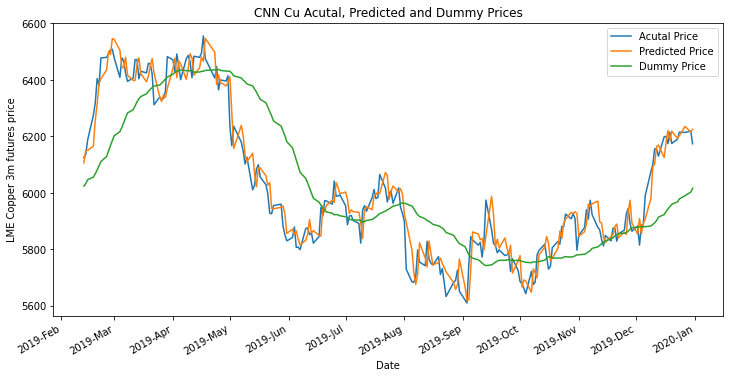

In [24]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

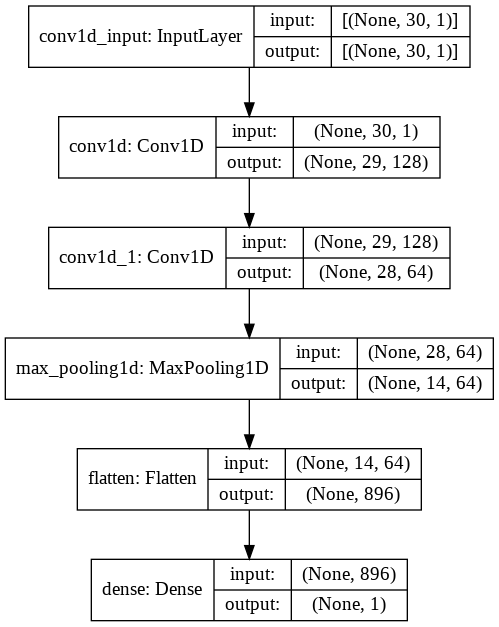

In [25]:
plot_model(model, show_shapes=True, expand_nested=True)

In [26]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003600490683533948
RMSE:  0.06000408889012438
MAE:  0.04784606058849431
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [27]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_Cu/assets
